In [5]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import math
from scipy import stats

##Inference about the mean of an unknown population

Data scientists often have to make inferences based on incomplete data. One such situation is when they are trying to make inferences about an unknown population based on one large random sample.

Suppose the goal is to try to estimate the population mean. We know that the sample mean is a good estimate if the sample size is large. But we expect it to be away from the population mean by about an SE of the sample average. To calculate that SE exactly, we need the population SD. But if the population data are unknown, we don't know the population SD. After all, we don't even know the population mean – that's what we are trying to estimte!

Fortunately, a simple approximation takes care of this. In the place of the population SD, we can simply use the SD of the sample. It will not be equal to the population SD, but when we divide it by $\sqrt{\mbox{sample size}}$, the error is greatly reduced and the approximation works.

$$
\mbox{SE of the sample average} ~=~
\frac{\mbox{Population SD}}{\sqrt{\mbox{sample size}}}
~~\approx~~ \frac{\mbox{sample SD}}{\sqrt{\mbox{sample size}}} ~~~
\mbox{when the random sample is large}
$$


###Use in estimation

As a consequence of the Central Limit Theorem, we can use proportions derived from the normal curve in statements about the distance between the sample mean and the population mean. 

For example, in about 95% of the samples:

- the sample average is in the range "population average $~\pm~$ 2 $\times$ SE of sample average"

This statement is equivalent to the following:

** In about 95% of the samples:**

- **the population average is in the range "sample average $~\pm~$ 2 $\times$ SE of sample average"**

This gives rise to a method of estimating the population mean.

###An approximate 95%-confidence interval for the population mean
A *confidence interval* is a range of estimates. An *approximate 95%-confidence interval for the population mean* is given by:

$$
\mbox{sample average} ~\pm~ 2 \times \mbox{SE of sample average}
$$

We estimate that the population mean will be in this range.

The confidence is in the procedure.
If we repeat this procedure many times, we will get many intervals, one for each repetition. About 95% of the intervals will contain the population average, which is what we are trying to estimate.

The *level of confidence*, 95%, can be replaced by any percent. The number of SEs on either side of the sample average has to be adjusted accordingly, by using the normal curve.

The table ``baby`` contains data on a random sample of 1,174 mothers and their newborn babies. The column ``birthwt`` contains the birth weight of the baby, in ounces; ``gest_days`` is the number of gestational days, that is, the number of days the baby was in the womb. There is also data on maternal age, maternal height, maternal pregnancy weight, and whether or not the mother was a smoker.

We will examine this datset in some detail in the following sections. For now, we will concentrate on the column ``mat_age``. This is the age of the mother, in years, when she gave birth. The goal is to try to estimate the average age of the women giving birth in the population.

In [6]:
baby = Table.read_table('baby.csv')
baby

birthwt,gest_days,mat_age,mat_ht,mat_pw,m_smoker
120,284,27,62,100,0
113,282,33,64,135,0
128,279,28,64,115,1
108,282,23,67,125,1
136,286,25,62,93,0
138,244,33,62,178,0
132,245,23,65,140,0
120,289,25,62,125,0
143,299,30,66,136,1
140,351,27,68,120,0


Here is a histogram of the ages of the new mothers in the sample. Most of the women were in the mid-twenties to low thirties.

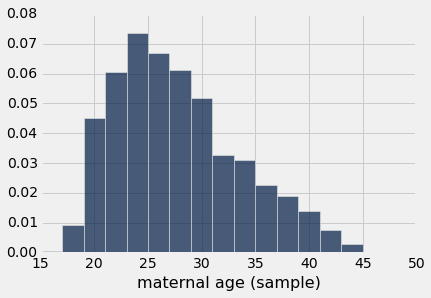

In [7]:
baby.select(['mat_age']).hist(bins=np.arange(15, 48, 2),normed=True)
plots.xlabel('maternal age (sample)')

###Estimate the average age of mothers in the population

The center of our interval is 27.23 years, the average age of the mothers in the sample.

In [8]:
samp_mean = np.mean(baby['mat_age'])
samp_mean

27.228279386712096

The sample average differs from the population average (which we are trying to estimate) by about an SE of the sample average. That's about 0.17 years.

In [30]:
SE_samp_ave = np.std(baby['mat_age'])/np.sqrt(baby.num_rows)   # approx
SE_samp_ave

0.16972373742299796

So an approximate 95%-confidence interval for the average age of the mothers in the population is "27.23 years $\pm$ 2$\times$0.17 years". The final answer:

**An approximate 95%-confidence interval for the average maternal age in the population:**

26.89 years to 27.57 years

**Exercise.**
True or false: About 95% of the mothers in the population are between 26.89 and 27.57 years old.

Answer: This cannot be right; 95% of women in the population are not all just around 27 years old. The interval simply estimates the average age of the women. In other words, it estimates that the histogram of the ages of all the women will balance somewhere in the range 26.89 years to 27.57 years.

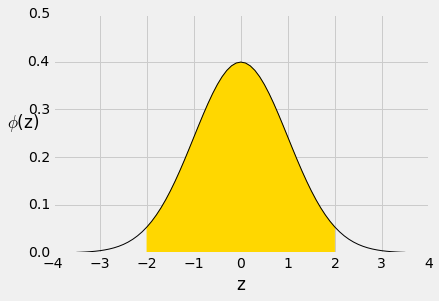

In [3]:
z = np.arange(-3.5, 3.6, 0.1)
plots.plot(z, stats.norm.pdf(z), color='k', lw=1)
w = np.arange(-2, 2.1, 0.1)
plots.fill_between(w, stats.norm.pdf(w), color='gold')
plots.ylim(0, 0.5)
plots.xlabel('z')
plots.ylabel('$\phi$(z)', rotation=0)

###Summary
The colored area in the graph above is 95%. It is the area under the standard normal curve, over the interval $-2$ to 2. Here is a brief summary of how this figure is connected to the construction of confidence intervals.

- No matter what the shape of the distribution of the population, the probability histogram for the sample means looks roughly normal, provided the random sample is large.
- We don't know the value of the center in the original units; that's the population mean, and that's what we're trying to estimate. In standard units, it is 0.
- We are hoping that our sample average comes out in the yellow interval. That way, going 2 SEs on either side will cover the center. The population mean will lie in the interval that we have constructed.
- We know that 1 SE of the sample average is equal to 1 on the standard units scale above.
- Even though we don't know the value of 0 on the original scale, We **can** estimate the value of 1 on the original scale; that's the SE of the sample average, approximately $\mbox{SampleSD}/\sqrt{\mbox{SampleSize}}$

###Special case: 0-1 variables

Suppose the data consist entirely of 0's and 1's. For example, suppose they are answers to a yes/no question, such as, "Are you currently a smoker?" Lists of zeros and ones have properties that simplify computation.

As an example, let us start with a list consisting of just one 0 and four 1's. Its average and SD can be computed as usual. Notice something interesting: the average of the list 0.8, is the proportion of 1's in it. And the SD of the list can be computed by a simple formula involving that proportion.

In [33]:
zero_one = [0, 1, 1, 1, 1]

In [34]:
# A proportion is a mean

np.mean(zero_one)           # p = 4/5 = proportion of 1's

0.80000000000000004

In [35]:
np.std(zero_one)

0.40000000000000008

In [36]:
np.sqrt(0.8*0.2)    

0.40000000000000002

**Facts about lists of 0's and 1's**

- The average is $p$, the proportion of 1's in the list.
- The SD is $\sqrt{p(1-p)}$

###Estimate the proportion of smokers among mothers in the population

To estimate the proportion of smokers among mothers in the population, we will start by finding the corresponding proportion in the sample. In the table, the code for "smoker" is 1 and the code for "non-smoker" is 0.

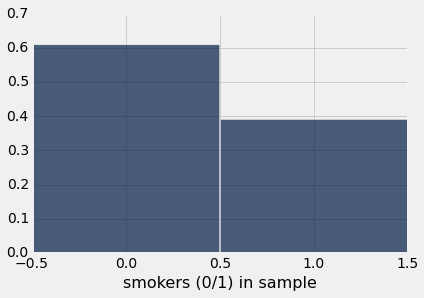

In [39]:
baby.select('m_smoker').hist(bins=np.arange(-0.5, 1.6, 1), normed=True)
plots.xlabel('smokers (0/1) in sample')

In the sample, about 39% of the mothers are smokers. This forms the center of our confidence interval.

In [13]:
# "One figure" estimate: the proportion of smokers in our sample

p_est = np.count_nonzero(baby['m_smoker'])/baby.num_rows
p_est

0.3909710391822828

The "give or take" number is the SE of the sample proportion, which is the SE for the sample mean because a proportion is just a mean of 0's and 1's. We know how to approximate the SE of a sample mean: divide the SD of the sample by the square root of the sample size. The sample consists of 0's and 1's, so its SD is given by the formula that we just observed. This allows us to compute the SE of the sample proportion, approximately.

In [14]:
# Give or take: SE of sample proportion
# That is, SE of sample mean where sample has only 0's and 1's
# SE of sample proportion approx equal to SampleSD/sqrt(SampleSize)

SE_samp_prop = np.sqrt(p_est*(1-p_est))/np.sqrt(baby.num_rows)         # approx
SE_samp_prop

0.014241548667026049

In [11]:
left = p_est - 2*SE_samp_prop
left

0.36248794184823074

In [12]:
right = p_est + 2*SE_samp_prop
right

0.4194541365163349

**An approximate 95%-confidence interval for proportion of smokers among women in the population**

0.39 $\pm$ 2$\times$0.14 = 0.3625 to 0.4194

That is, an approximate 95%-confidence interval for the percent of smokers among the mothers in the population is 36.25% to 41.95%.